# Exploring Class of Device
This notebook explores the class of device property of Bluetooth devices to try to isolate purely automobile observations relative to other modes (bike, ped, transit).

In [1]:
from psycopg2 import connect
import psycopg2.sql as pg
import configparser
import datetime
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(color_codes=True)
from IPython.display import HTML
def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

In [2]:
CONFIG = configparser.ConfigParser()
CONFIG.read('../../db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [71]:
sql = '''WITH total_cnt AS (SELECT sum(good_count) AS sum_total FROM rdumas.bt_cod_counts)

SELECT cod, device_type, to_char(sum(good_count), '999,999,999') AS "Number of observations",
to_char(100.0*sum(good_count)/sum_total, '99.9')||'%' AS "Proportion of Observations"
FROM rdumas.bt_cod_counts
INNER JOIN bluetooth.class_of_device USING (cod)
CROSS JOIN total_cnt
GROUP BY cod, device_type, sum_total
ORDER BY sum(good_count) DESC
LIMIT 10'''
print_table(sql, con)

cod,device_type,Number of observations,Proportion of Observations
0,WiFi,"86,362,014",42.6%
7995916,Smart phone,"38,399,399",19.0%
2098184,Hands-free Device,"26,912,142",13.3%
3408904,Hands-free Device,"12,235,225",6.0%
3146760,Hands-free Device,"6,436,542",3.2%
5898756,Cellular,"6,269,605",3.1%
5898764,Smart phone,"5,683,055",2.8%
5767684,Cellular,"3,146,918",1.6%
2360324,Wearable Headset Device,"2,802,408",1.4%
2360328,Hands-free Device,"1,534,825",.8%


`cod == 0` are WiFi devices. We're not entirely sure what they are, but I suspect strongly that they are smart phones with WiFi. [Because Bluetooth and WiFi addresses are different](https://stackoverflow.com/a/32732558/4047679) there's no way of knowing these are the same device (though an examination of timestamps and speeds could probably reveal this). So there may very likely be double-counting of smartphones that have Bluetooth and WiFi enabled.

Comparing the distribution of device types from the DVP and Adelaide

In [73]:
sql = pg.SQL('''
WITH total_cnt AS (
    SELECT start_road, sum(good_count) AS sum_total FROM rdumas.bt_cod_counts 
    INNER JOIN bluetooth.ref_segments USING (analysis_id)
    WHERE ARRAY[start_road::TEXT] <@ {road_names}
    GROUP BY start_road
) 
SELECT start_road AS "Route", device_type, 100.0*SUM(good_count)/sum_total AS "Proportion of Observations"
FROM rdumas.bt_cod_counts
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN total_cnt USING (start_road)
GROUP BY  "Route", device_type, sum_total
ORDER BY SUM(good_count)/sum_total DESC
LIMIT 10''')

dvp_adelaide = pandasql.read_sql(sql.format(road_names = pg.Literal(['DVP','Adelaide'])), con)


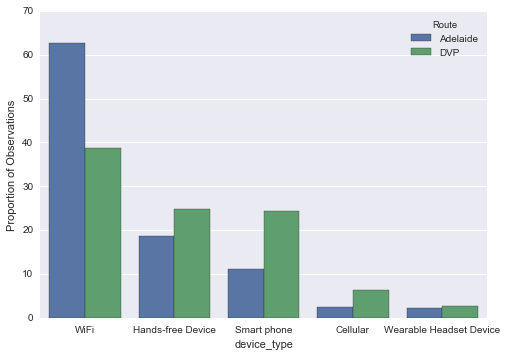

In [74]:
ax = sns.barplot(x='device_type', y="Proportion of Observations", hue='Route', data=dvp_adelaide)
ax.set_ylabel('Proportion of Observations')

The chart above shows a much greater proportion of WIFI devices on Adelaide --a major arterial with a protected bike-lane-- than on the DVP --a major expressway--. We can infer then that people travelling in non-car modes are more likely to have  WIFI devices enabled than a smart phone or cell phone with Bluetooth enabled. 

In [3]:
resultid = pg.Literal('BA3_BA2')
analysis_hour = pg.Literal(datetime.datetime(2016,11,2,7))
sql = pg.SQL('''SELECT measured_timestamp, 3.6*length_m/measured_time as speed, device_type
FROM bluetooth.observations
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE segment_name = {resultid} AND outlier_level = 0
AND measured_timestamp BETWEEN {analysis_hour}::TIMESTAMP AND {analysis_hour}::TIMESTAMP + INTERVAL '3 hour'
AND device_type IN ('WiFi', 'Hands-free Device', 'Cellular', 'Smart phone')
''').format(resultid = resultid, analysis_hour = analysis_hour)

adelaide_devices = pandasql.read_sql(sql, con)

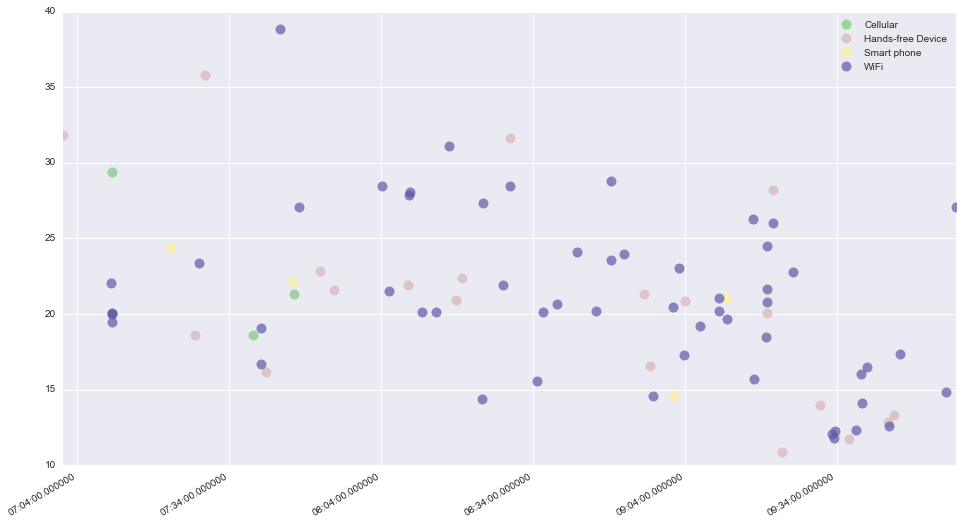

In [4]:
groups = adelaide_devices.groupby('device_type')

fig, ax = plt.subplots(1,1,figsize=(16,9))
NUM_COLORS = 5
cm = plt.get_cmap('Accent')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

for i, (device_type, data) in enumerate(groups):
    ax.plot(data.measured_timestamp, data.speed, marker='o', markersize=10,
            alpha=0.7, linestyle='', label=device_type, color=colors[i])
ax.legend()
plt.gcf().autofmt_xdate()

Looking at a few weekend days

In [8]:
resultid = pg.Literal('BA3_BA2')
analysis_hour = pg.Literal(datetime.datetime(2016,10,2,7))
sql = pg.SQL('''SELECT measured_timestamp, 3.6*length_m/measured_time as speed, device_type
FROM bluetooth.observations
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE segment_name = {resultid} AND outlier_level = 0
AND measured_timestamp BETWEEN {analysis_hour}::TIMESTAMP AND {analysis_hour}::TIMESTAMP + INTERVAL '8 hour'
AND device_type IN ('WiFi', 'Hands-free Device', 'Cellular', 'Smart phone')
''').format(resultid = resultid, analysis_hour = analysis_hour)

adelaide_devices = pandasql.read_sql(sql, con)

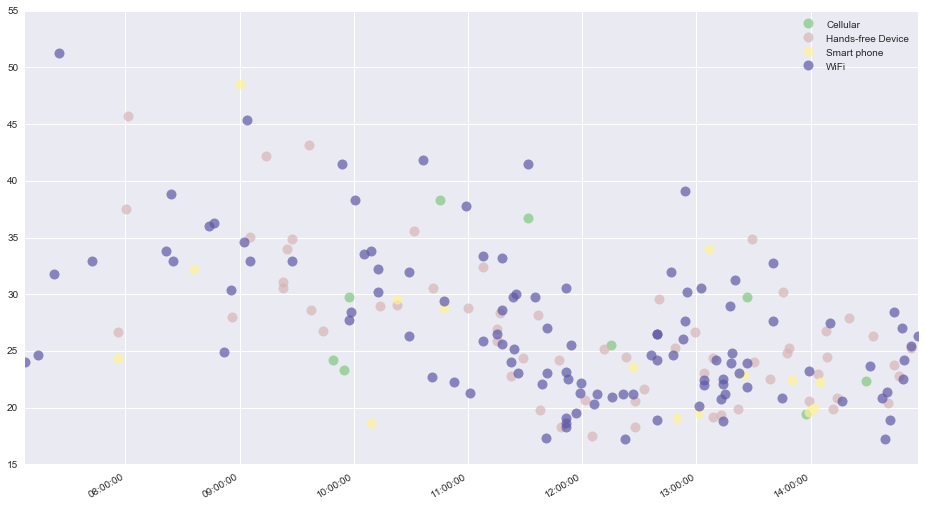

In [9]:
groups = adelaide_devices.groupby('device_type')

fig, ax = plt.subplots(1,1,figsize=(16,9))
NUM_COLORS = 5
cm = plt.get_cmap('Accent')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

for i, (device_type, data) in enumerate(groups):
    ax.plot(data.measured_timestamp, data.speed, marker='o', markersize=10,
            alpha=0.7, linestyle='', label=device_type, color=colors[i])
ax.legend()
plt.gcf().autofmt_xdate()

The scatter plots of individual dates don't show any detectable patterns between the 4 category of device. This would hint that it would be hard to determine whether real-time speeds are affected by cyclists or not. This next series of plots will attempt to detect trends over 1 month of data by using a swarm plot aggregated by 15-min bin.

In [11]:
resultid = pg.Literal('BA3_BA2')
analysis_hour = pg.Literal(datetime.time(8))
sql = pg.SQL('''SELECT (EXTRACT(hour from measured_timestamp::TIME)::TEXT ||':'|| (trunc(EXTRACT(minute from measured_timestamp::TIME)/15)*15)::TEXT)::TIME as timebin,
3.6*length_m/measured_time as speed, device_type
FROM bluetooth.observations
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE segment_name = {resultid} AND outlier_level = 0
AND measured_timestamp::TIME BETWEEN {analysis_hour}::TIME AND {analysis_hour}::TIME + INTERVAL '1 hour'
AND EXTRACT('isodow' FROM measured_timestamp) BETWEEN 2 and 4
AND device_type IN ('WiFi', 'Hands-free Device', 'Cellular', 'Smart phone')
ORDER BY device_type, timebin
''').format(resultid = resultid, analysis_hour = analysis_hour)

adelaide_october = pandasql.read_sql(sql, con)

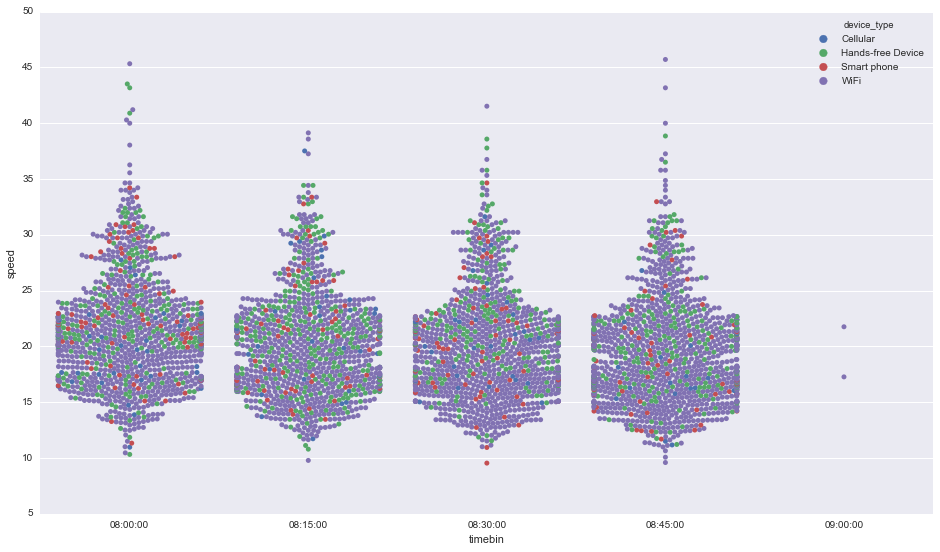

In [12]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
swarm = sns.swarmplot(x='timebin', y='speed', hue='device_type', data=adelaide_october, ax=ax)

Since there's a bit too much data, let's have a better look at the distributions. Comparing the two main device types.

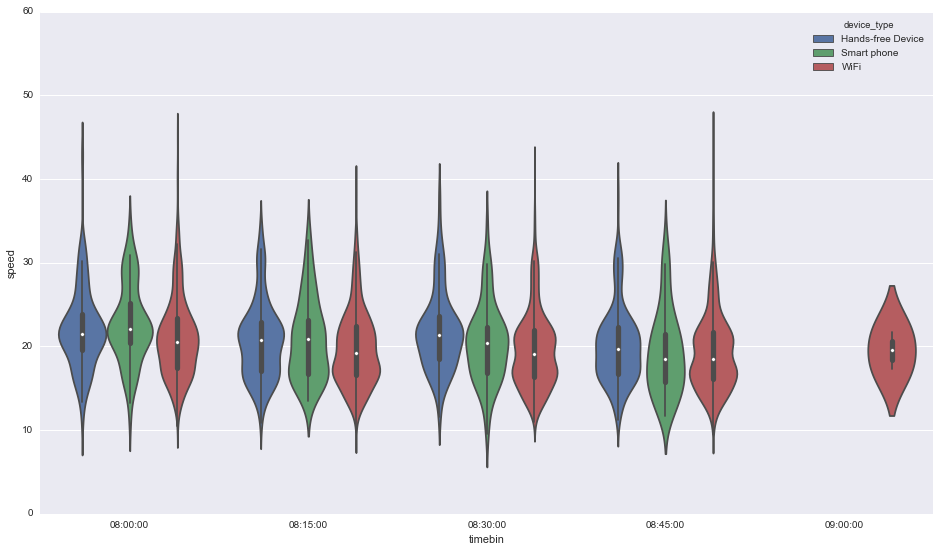

In [13]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
violin = sns.violinplot(x='timebin', y='speed', hue='device_type',
                        data=adelaide_october[adelaide_october['device_type'].isin(['WiFi','Hands-free Device', 'Smart phone'])],
                        ax=ax)

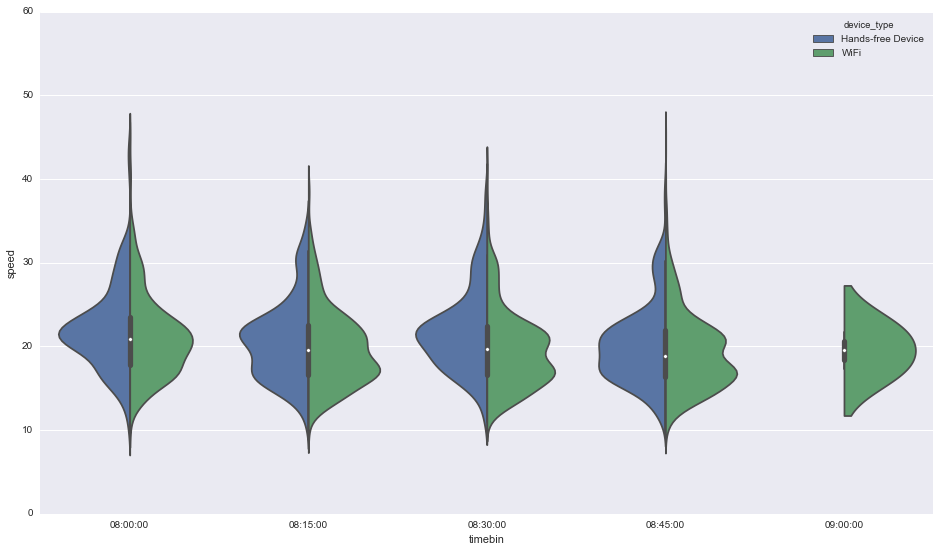

In [14]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
violin = sns.violinplot(x='timebin', y='speed', hue='device_type',
                        data=adelaide_october[adelaide_october['device_type'].isin(['WiFi','Hands-free Device'])],
                        split=True, ax=ax)

In the plot above the WiFi class seems a little more bottom heavy than hands-free, implying it could have a higher proportion of slower vehicles, possibly cyclists. Now looking at the overall Midweek AM Peak for the four main device classes, the difference between the WiFi class and the others striking.

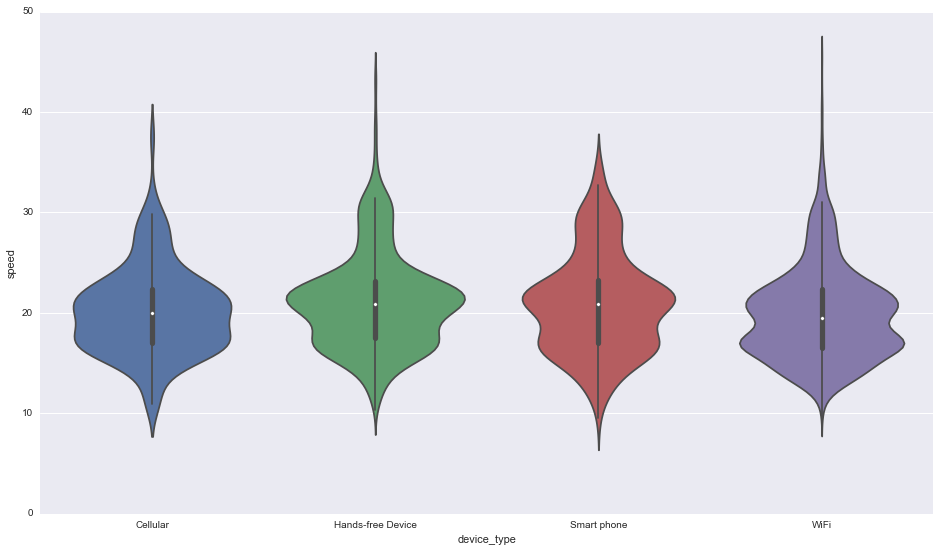

In [15]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
violin = sns.violinplot(x='device_type', y='speed', data=adelaide_october, ax=ax)

Looking at a day of week comparison for the AM

In [8]:
startroad = pg.Literal('Adelaide')
analysis_hour = pg.Literal(datetime.time(8))
sql = pg.SQL('''SELECT CASE EXTRACT('isodow' FROM measured_timestamp)
WHEN 1 THEN 'Monday'
WHEN 5 THEN 'Friday'
WHEN 6 THEN 'Saturday'
WHEN 7 THEN 'Sunday' 
ELSE 'MidWeek' END  AS "Day of Week",
CASE WHEN measured_time < 20 THEN NULL ELSE 3.6*length_m/measured_time END as speed, device_type
FROM bluetooth.observations
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE start_road = {start_road} AND outlier_level = 0 
AND measured_timestamp::TIME BETWEEN {analysis_hour}::TIME AND {analysis_hour}::TIME + INTERVAL '1 hour'
AND device_type IN ('WiFi', 'Hands-free Device', 'Cellular', 'Smart phone')
ORDER BY device_type
''').format(start_road = startroad, analysis_hour = analysis_hour)

adelaide_october_dow = pandasql.read_sql(sql, con)

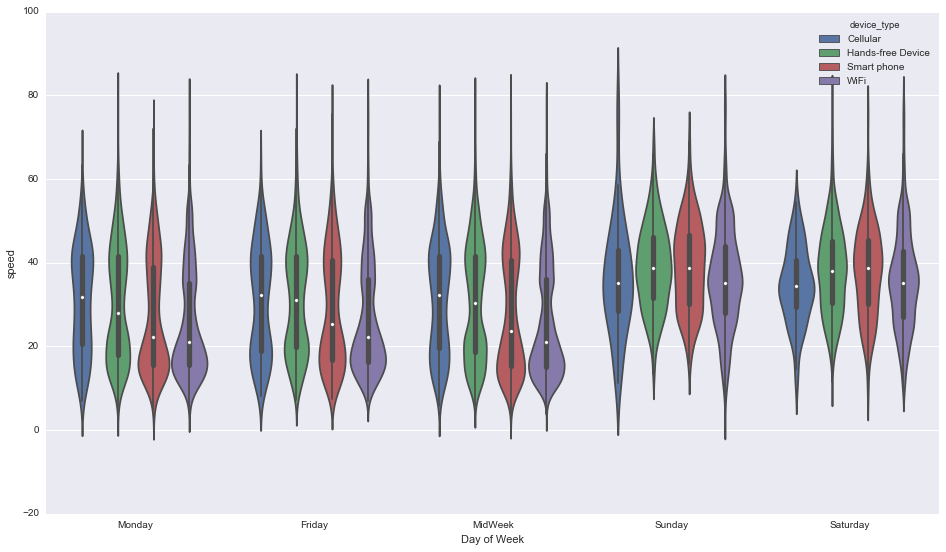

In [9]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
swarm = sns.violinplot(x="Day of Week", y='speed', hue='device_type', data=adelaide_october_dow, ax=ax)

Looking instead at Richmond in the PM 

In [16]:
startroad = pg.Literal('Richmond')
analysis_hour = pg.Literal(datetime.time(16))
sql = pg.SQL('''SELECT CASE EXTRACT('isodow' FROM measured_timestamp)
WHEN 1 THEN 'Monday'
WHEN 5 THEN 'Friday'
WHEN 6 THEN 'Saturday'
WHEN 7 THEN 'Sunday' 
ELSE 'MidWeek' END  AS "Day of Week",
CASE WHEN measured_time < 20 THEN NULL ELSE 3.6*length_m/measured_time END as speed, device_type
FROM bluetooth.observations
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE start_road = {start_road} AND outlier_level = 0 
AND measured_timestamp::TIME BETWEEN {analysis_hour}::TIME AND {analysis_hour}::TIME + INTERVAL '1 hour'
AND device_type IN ('WiFi', 'Hands-free Device', 'Cellular', 'Smart phone')
ORDER BY device_type
''').format(start_road = startroad, analysis_hour = analysis_hour)

richmond_october_dow = pandasql.read_sql(sql, con)

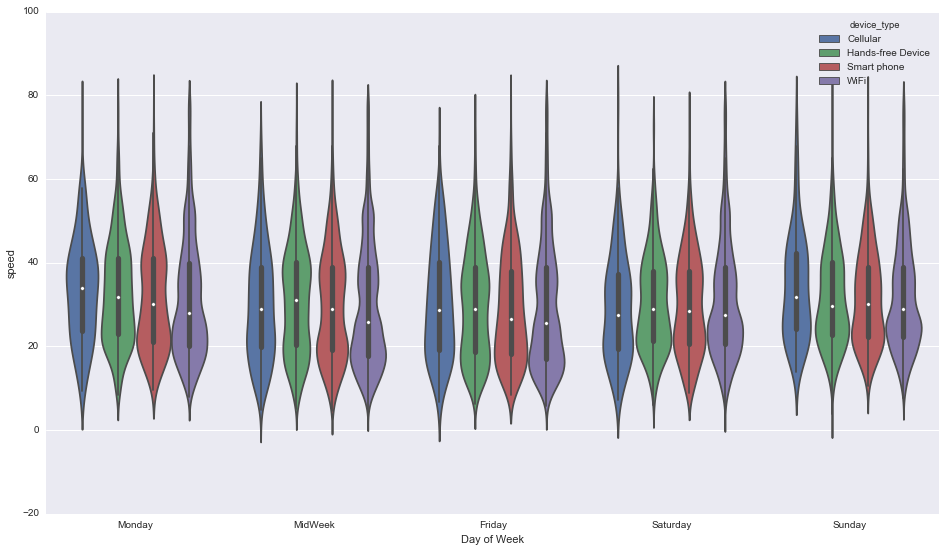

In [17]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
swarm = sns.violinplot(x="Day of Week", y='speed', hue='device_type', data=richmond_october_dow, ax=ax)

### Caveat
It's important to bear in mind here that over 60% of observations are from WiFi devices and in slowdown conditions there are likely more vehicles being observed, so it could make sense that the distribution of WiFi tends to lower speeds than other device types. This next secton will look instead at observations aggregated to 5-min bins.

### 5-min bin observations
Looking at how using only Bluetooth decreases the number of 5-min observations and affects averages from these observations

In [33]:
oct_bt_5min = '''CREATE MATERIALIZED VIEW rdumas.bluetooth_oct AS 

SELECT date_trunc('hour', measured_timestamp) + trunc(EXTRACT(minute from measured_timestamp)/5)* interval '5 minute' as datetime_bin,
analysis_id,
percentile_cont(0.5) WITHIN GROUP (ORDER BY measured_time) as tt, COUNT(1) AS obs
FROM bluetooth.observations
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE start_road IN ('Richmond', 'Adelaide') AND outlier_level = 0
AND measured_timestamp >= '2016-10-01'::DATE AND measured_timestamp < '2016-11-01'::DATE + INTERVAL '1 month'
AND device_type != 'WiFi'
GROUP BY analysis_id, datetime_bin '''
with con:
    with con.cursor() as cur:
        cur.execute(oct_bt_5min)


In [65]:
resultid = pg.Literal('BA3_BA2')
analysis_date = pg.Literal(datetime.datetime(2016,10,5))
bt_wifi_day_compare = pg.SQL('''SELECT datetime_bin, 3.6*length_m/bt.tt as "Bluetooth Only",
3.6*length_m/bt_all.tt as "Bluetooth + WiFi"
FROM rdumas.bluetooth_oct bt
RIGHT OUTER JOIN bluetooth.aggr_5min bt_all USING (analysis_id, datetime_bin)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE segment_name = {resultid} 
AND datetime_bin BETWEEN {analysis_date}::TIMESTAMP + INTERVAL '6 hours' 
    AND {analysis_date}::TIMESTAMP + INTERVAL '18 hour'
''').format(resultid = resultid, analysis_date = analysis_date)

bt_wifi_day = pandasql.read_sql(bt_wifi_day_compare, con)

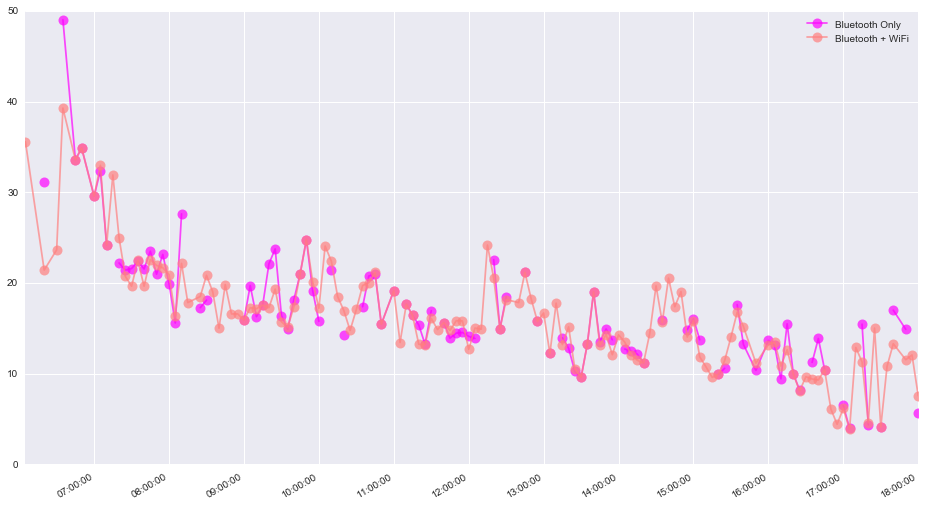

In [66]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
NUM_COLORS = 2
cm = plt.get_cmap('spring')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

ax.plot(bt_wifi_day.datetime_bin, bt_wifi_day["Bluetooth Only"], marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="Bluetooth Only", color=colors[0])

ax.plot(bt_wifi_day.datetime_bin, bt_wifi_day["Bluetooth + WiFi"], marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="Bluetooth + WiFi", color=colors[1])

ax.legend()
plt.gcf().autofmt_xdate()

In [78]:
pk_hour = 8
pk_avg = pg.SQL('''SELECT resultid,
    3.6*length_m/AVG(bt.tt) AS "BT AVG Speed", 3.6*length_m/stddev(bt.tt) AS "BT STD Speed", COUNT(bt.tt) AS "Num Time Bins", 
    3.6*length_m/AVG(bt_all.tt) AS "BT-WiFi AVG Speed", 3.6*length_m/stddev(bt_all.tt) AS "BT-WiFi STD Speed", COUNT(bt_all.tt) AS "Num Time Bins"
FROM bluetooth.aggr_5min bt_all 
INNER JOIN bluetooth.ref_segments USING (analysis_id)
LEFT OUTER JOIN rdumas.bluetooth_oct bt USING (analysis_id, datetime_bin)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE EXTRACT('hour' FROM datetime_bin) = {pk_hour} AND EXTRACT('isodow' FROM datetime_bin) < 6
AND start_road IN ('Richmond', 'Adelaide') AND datetime_bin >= '2016-10-01'::DATE AND datetime_bin < '2016-10-01'::DATE + INTERVAL '1 month'
GROUP BY resultid, length_m 
                                    
'''.format(pk_hour=pk_hour))
print_table(pk_avg, con)

resultid,BT AVG Speed,BT STD Speed,Num Time Bins,BT-WiFi AVG Speed,BT-WiFi STD Speed,Num Time Bins
BA2_BA1,37.100345,142.999369,241,37.309060,199.981395,251
BA3_BA2,19.253620,95.904671,149,18.648606,103.704986,235
BA4_BA3,13.846919,51.393276,230,14.090241,57.337982,246
BR1_BR2,31.019436,113.869772,247,30.895958,94.860727,251
BR2_BR3,10.154879,30.421035,61,10.150797,34.156504,141
BR3_BR4,24.589336,84.557245,139,23.926022,88.302008,225


In [80]:
oct_handsfree_5min = '''CREATE MATERIALIZED VIEW rdumas.handfree_oct_nov AS 

SELECT date_trunc('hour', measured_timestamp) + trunc(EXTRACT(minute from measured_timestamp)/5)* interval '5 minute' as datetime_bin,
analysis_id,
percentile_cont(0.5) WITHIN GROUP (ORDER BY measured_time) as tt, COUNT(1) AS obs
FROM bluetooth.observations
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE start_road IN ('Richmond', 'Adelaide') AND outlier_level = 0
AND measured_timestamp >= '2016-10-01'::DATE AND measured_timestamp < '2016-11-01'::DATE + INTERVAL '1 month'
AND device_type = 'Hands-free Device'
GROUP BY analysis_id, datetime_bin '''
with con:
    with con.cursor() as cur:
        cur.execute(oct_handsfree_5min)


In [82]:
pk_hour = 17
pk_avg = pg.SQL('''SELECT resultid,
    3.6*length_m/AVG(bt.tt) AS "HF AVG Speed", 3.6*length_m/stddev(bt.tt) AS "HF STD Speed", COUNT(bt.tt) AS "Num Time Bins", 
    3.6*length_m/AVG(bt_all.tt) AS "BT-WiFi AVG Speed", 3.6*length_m/stddev(bt_all.tt) AS "BT-WiFi STD Speed", COUNT(bt_all.tt) AS "Num Time Bins"
FROM bluetooth.aggr_5min bt_all 
INNER JOIN bluetooth.ref_segments USING (analysis_id)
LEFT OUTER JOIN rdumas.handfree_oct_nov bt USING (analysis_id, datetime_bin)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE EXTRACT('hour' FROM datetime_bin) = {pk_hour} AND EXTRACT('isodow' FROM datetime_bin) < 6
AND start_road IN ('Richmond', 'Adelaide') AND datetime_bin >= '2016-10-01'::DATE AND datetime_bin < '2016-10-01'::DATE + INTERVAL '1 month'
GROUP BY resultid, length_m 
                                    
'''.format(pk_hour=pk_hour))
print_table(pk_avg, con)

resultid,HF AVG Speed,HF STD Speed,Num Time Bins,BT-WiFi AVG Speed,BT-WiFi STD Speed,Num Time Bins
BA2_BA1,34.673477,138.666410,240,33.152112,154.118294,252
BA3_BA2,8.180631,22.707364,126,8.546662,22.667681,244
BA4_BA3,12.740021,23.950053,102,12.227734,23.104918,245
BR1_BR2,32.437887,98.481647,217,35.303726,147.619163,252
BR2_BR3,8.916191,38.302881,35,9.004323,34.138247,125
BR3_BR4,13.220122,38.213447,134,14.262587,47.781496,245


Differences in averages seem minimal across the 6 segments looking at different peak hours and Bluetooth overall versus just "Hand's Free" devices. Redoing the violin plots from above with binned observations 

In [89]:
pk_hour = 8

agg_violin_sql = pg.SQL('''SELECT resultid, CASE EXTRACT('isodow' FROM datetime_bin)
WHEN 1 THEN 'Monday'
WHEN 5 THEN 'Friday'
WHEN 6 THEN 'Saturday'
WHEN 7 THEN 'Sunday' 
ELSE 'MidWeek' END  AS "Day of Week",
3.6*length_m/NULLIF(hf.tt,0) AS "Hands Free",
3.6*length_m/NULLIF(bt.tt,0) AS "Bluetooth (All)",
3.6*length_m/NULLIF(bt_all.tt,0) AS "Bluetooth + WiFi"
FROM bluetooth.aggr_5min bt_all 
INNER JOIN bluetooth.ref_segments USING (analysis_id)
LEFT OUTER JOIN rdumas.handfree_oct_nov hf USING (analysis_id, datetime_bin)
LEFT OUTER JOIN rdumas.bluetooth_oct bt USING (analysis_id, datetime_bin)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE EXTRACT('hour' FROM datetime_bin) = {pk_hour} 
AND start_road IN ('Richmond', 'Adelaide') AND datetime_bin >= '2016-10-01'::DATE AND datetime_bin < '2016-10-01'::DATE + INTERVAL '1 month'
'''.format(pk_hour=pk_hour))

agg_violin_data = pandasql.read_sql(agg_violin_sql, con)

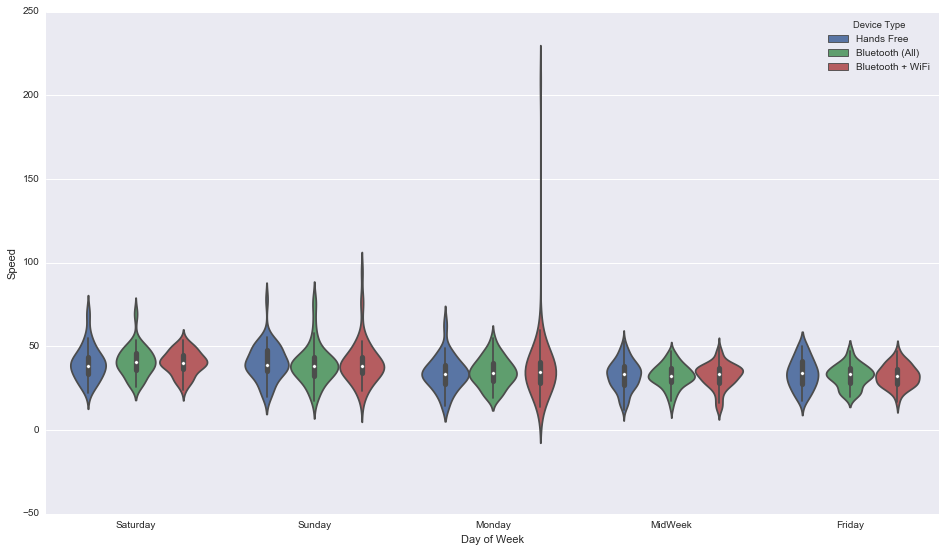

In [92]:
fig, ax = plt.subplots(1,1,figsize=(16,9))

data = pd.melt( agg_violin_data[agg_violin_data.resultid == 'BR1_BR2'], id_vars=['resultid','Day of Week'], 
              value_vars=["Hands Free","Bluetooth (All)","Bluetooth + WiFi"], var_name='Device Type', value_name='Speed')

swarm = sns.violinplot(x="Day of Week", y='Speed', hue='Device Type', data=data, ax=ax)

## Hexbin Plots
Comparing 5-min aggregated observations by device type. 

In [8]:
device_type_5min = '''CREATE MATERIALIZED VIEW rdumas.bluetooth_device_type_aggr_oct_nov AS 

SELECT date_trunc('hour', measured_timestamp) + trunc(EXTRACT(minute from measured_timestamp)/5)* interval '5 minute' as datetime_bin,
analysis_id, device_type,
percentile_cont(0.5) WITHIN GROUP (ORDER BY measured_time) as tt, COUNT(1) AS obs
FROM bluetooth.observations
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE start_road IN ('Richmond', 'Adelaide') AND outlier_level = 0
AND measured_timestamp >= '2016-10-01'::DATE AND measured_timestamp < '2016-11-01'::DATE + INTERVAL '1 month'
AND device_type IN ('WiFi', 'Hands-free Device', 'Cellular', 'Smart phone')
GROUP BY analysis_id, datetime_bin, device_type '''
with con:
    with con.cursor() as cur:
        cur.execute(device_type_5min)


In [3]:
hex_plot_sql = '''SELECT resultid, date_trunc('hour', datetime_bin),
3.6*length_m/NULLIF(hf.tt,0) AS "Hands Free",
3.6*length_m/NULLIF(bt.tt,0) AS "Bluetooth (All)",
3.6*length_m/NULLIF(bt_all.tt,0) AS "Bluetooth + WiFi"
FROM bluetooth.aggr_5min bt_all 
INNER JOIN bluetooth.ref_segments USING (analysis_id)
LEFT OUTER JOIN rdumas.handfree_oct_nov hf USING (analysis_id, datetime_bin)
LEFT OUTER JOIN rdumas.bluetooth_oct bt USING (analysis_id, datetime_bin)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE start_road IN ('Richmond', 'Adelaide') AND datetime_bin >= '2016-10-01'::DATE AND datetime_bin < '2016-10-01'::DATE + INTERVAL '1 month'
'''   
hex_plot_data = pandasql.read_sql(hex_plot_sql, con)

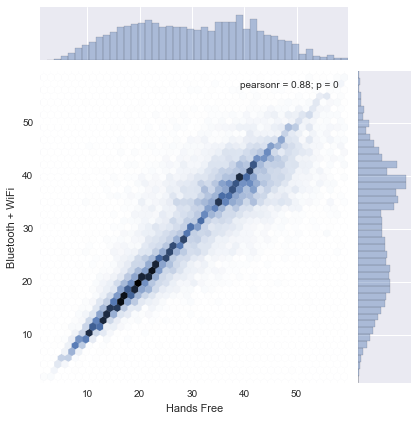

In [4]:
data = (hex_plot_data[["Hands Free","Bluetooth + WiFi"]]).dropna()
data = data[(data["Hands Free"] < 60) & (data["Bluetooth + WiFi"] < 60)]
ax = sns.jointplot(data["Hands Free"], data["Bluetooth + WiFi"], kind='hex')

In [18]:
hex_plot_sql = '''SELECT resultid, datetime_bin,
3.6*length_m/NULLIF(tt,0) AS "Speed",
device_type
FROM rdumas.bluetooth_device_type_aggr_oct_nov  
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE start_road IN ('Richmond', 'Adelaide') AND 3.6*length_m/NULLIF(tt,0) < 60
ORDER BY resultid, datetime_bin, device_type
'''   
hex_plot_data = pandasql.read_sql(hex_plot_sql, con)

In [19]:
hex_plot_data = hex_plot_data.pivot_table(columns='device_type', values="Speed", index=['resultid','datetime_bin'])

In [20]:
hex_plot_data

device_type                    Cellular  Hands-free Device  Smart phone  \
resultid datetime_bin                                                     
BA2_BA1  2016-10-01 00:00:00  40.615385          39.600000    33.000000   
         2016-10-01 00:05:00        NaN          45.913043          NaN   
         2016-10-01 00:10:00  45.257143          44.000000          NaN   
         2016-10-01 00:15:00        NaN          31.058824    36.837209   
         2016-10-01 00:20:00        NaN          37.270588    38.634146   
         2016-10-01 00:25:00        NaN                NaN    45.257143   
         2016-10-01 00:30:00  39.600000          39.600000          NaN   
         2016-10-01 00:35:00        NaN          20.842105    42.810811   
         2016-10-01 00:40:00  46.588235          51.096774          NaN   
         2016-10-01 00:45:00        NaN          49.500000    40.615385   
         2016-10-01 00:50:00        NaN          37.714286    54.620690   
         2016-10-01 00:55:00        NaN                NaN          NaN   
         2016-10-01 01:00:00        NaN                NaN          NaN   
         2016-10-01 01:05:00        NaN                NaN          NaN   
         2016-10-01 01:10:00        NaN          42.240000          NaN   
         2016-10-01 01:15:00        NaN                NaN          NaN   
         2016-10-01 01:20:00        NaN                NaN          NaN   
         2016-10-01 01:25:00        NaN          52.800000    52.800000   
         2016-10-01 01:30:00        NaN          45.257143    20.050633   
         2016-10-01 01:35:00        NaN                NaN    36.837209   
         2016-10-01 01:40:00        NaN          37.714286          NaN   
         2016-10-01 01:45:00  35.200000          42.810811          NaN   
         2016-10-01 01:50:00        NaN                NaN          NaN   
         2016-10-01 01:55:00        NaN          42.810811          NaN   
         2016-10-01 02:00:00        NaN                NaN    35.200000   
         2016-10-01 02:05:00        NaN                NaN          NaN   
         2016-10-01 02:10:00        NaN          45.257143    46.588235   
         2016-10-01 02:15:00        NaN          48.000000          NaN   
         2016-10-01 02:20:00        NaN          45.257143    58.666667   
         2016-10-01 02:25:00        NaN                NaN    35.200000   
...                                 ...                ...          ...   
BR3_BR4  2016-11-30 21:25:00        NaN          21.220144    30.725000   
         2016-11-30 21:30:00        NaN                NaN          NaN   
         2016-11-30 21:35:00        NaN          25.798251          NaN   
         2016-11-30 21:40:00        NaN                NaN    24.309890   
         2016-11-30 21:45:00        NaN          24.111172          NaN   
         2016-11-30 21:50:00        NaN          28.361538    28.544516   
         2016-11-30 21:55:00        NaN                NaN          NaN   
         2016-11-30 22:00:00        NaN          24.511911    26.025882   
         2016-11-30 22:05:00        NaN          20.771831          NaN   
         2016-11-30 22:10:00        NaN          23.915676    21.169378   
         2016-11-30 22:15:00        NaN          26.814545          NaN   
         2016-11-30 22:20:00  24.717318                NaN          NaN   
         2016-11-30 22:25:00        NaN                NaN          NaN   
         2016-11-30 22:30:00        NaN          17.487747    20.436028   
         2016-11-30 22:35:00        NaN                NaN    17.418898   
         2016-11-30 22:40:00        NaN                NaN          NaN   
         2016-11-30 22:45:00        NaN                NaN          NaN   
         2016-11-30 22:50:00        NaN          22.289169    28.002532   
         2016-11-30 22:55:00  27.143558                NaN    23.534043   
         2016-11-30 23:00:00  39.859459                NaN          NaN   
         2016-11-30 23:05

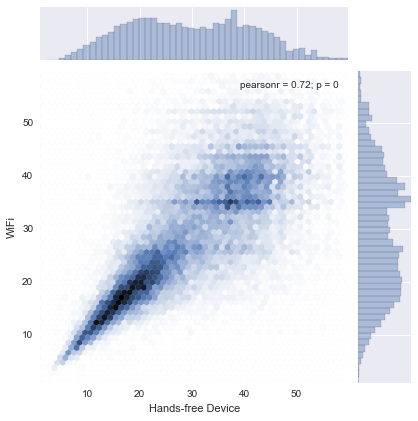

In [21]:
data = (hex_plot_data[["Hands-free Device","WiFi"]]).dropna()
ax = sns.jointplot(data["Hands-free Device"], data["WiFi"], kind='hex')

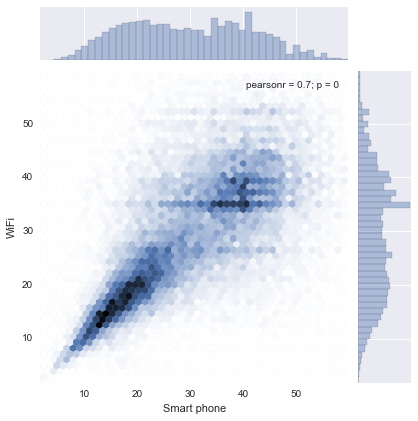

In [22]:
data = (hex_plot_data[["Smart phone","WiFi"]]).dropna()
ax = sns.jointplot(data["Smart phone"], data["WiFi"], kind='hex')

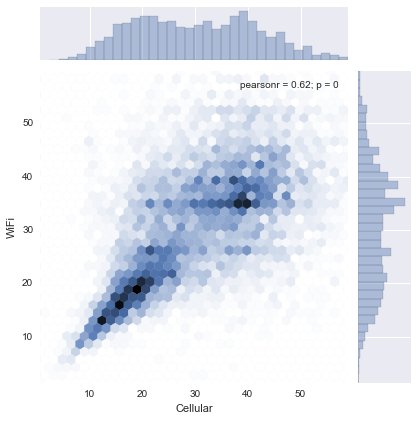

In [23]:
data = (hex_plot_data[["Cellular","WiFi"]]).dropna()
ax = sns.jointplot(data["Cellular"], data["WiFi"], kind='hex')

In [34]:
bt_wifi_sql = '''SELECT resultid, datetime_bin,
3.6*length_m/NULLIF(bt_all.tt,0) AS "BT Speed",
3.6*length_m/NULLIF(wifi.tt,0) AS "WiFi Speed"
FROM rdumas.bluetooth_device_type_aggr_oct_nov  wifi
INNER JOIN bluetooth_oct bt_all USING (analysis_id, datetime_bin)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE start_road IN ('Richmond', 'Adelaide') AND device_type = 'WiFi'
AND 3.6*length_m/NULLIF(bt_all.tt,0) < 60 AND 3.6*length_m/NULLIF(wifi.tt,0) < 60
ORDER BY resultid, datetime_bin '''
bt_wifi_data = pandasql.read_sql(bt_wifi_sql, con)

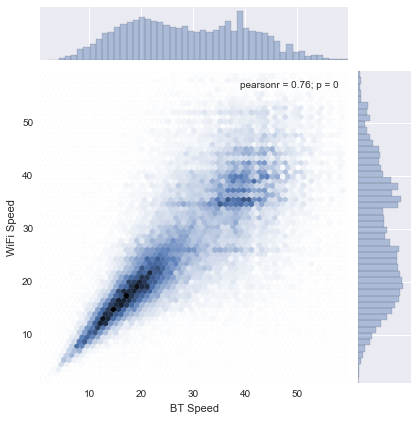

In [35]:
ax = sns.jointplot(bt_wifi_data["BT Speed"], bt_wifi_data["WiFi Speed"], kind='hex')

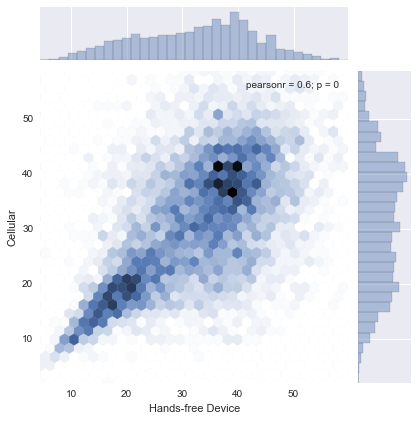

In [27]:
data = (hex_plot_data[["Hands-free Device","Smart phone"]]).dropna()
ax = sns.jointplot(data["Hands-free Device"], data["Smart phone"], kind='hex')

The plots above highlight some peculiarities in the observations: the aggregated 5-min observations based on WiFi seem to have unusual concentrations at specific speeds between 30 and 40 km/hr. This seems to be particularly driven by the `BA2_BA1` segment as evidenced by the table below.

In [25]:
sql = '''SELECT resultid, trunc(3.6*length_m/NULLIF(tt,0)) speed, COUNT(1) AS "Num 5-min bins"

  FROM bluetooth_device_type_aggr_oct_nov
  INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
  WHERE device_type = 'WiFi' AND trunc(3.6*length_m/NULLIF(tt,0)) between 30 and 40 AND resultid = 'BA2_BA1'
  GROUP BY speed, resultid
  ORDER BY resultid, speed '''
print_table(sql, con)

resultid,speed,Num 5-min bins
BA2_BA1,30.0,269
BA2_BA1,31.0,453
BA2_BA1,32.0,346
BA2_BA1,33.0,596
BA2_BA1,34.0,779
BA2_BA1,35.0,1152
BA2_BA1,36.0,1176
BA2_BA1,37.0,769
BA2_BA1,38.0,775
BA2_BA1,39.0,1065


In [24]:
hex_plot_data.reset_index()

device_type,resultid,datetime_bin,Cellular,Hands-free Device,Smart phone,WiFi
0,BA2_BA1,2016-10-01 00:00:00,40.615385,39.600000,33.000000,38.168675
1,BA2_BA1,2016-10-01 00:05:00,NaN,45.913043,NaN,52.800000
2,BA2_BA1,2016-10-01 00:10:00,45.257143,44.000000,NaN,38.168675
3,BA2_BA1,2016-10-01 00:15:00,NaN,31.058824,36.837209,13.090909
4,BA2_BA1,2016-10-01 00:20:00,NaN,37.270588,38.634146,34.434783
5,BA2_BA1,2016-10-01 00:25:00,NaN,NaN,45.257143,36.413793
6,BA2_BA1,2016-10-01 00:30:00,39.600000,39.600000,NaN,40.101266
7,BA2_BA1,2016-10-01 00:35:00,NaN,20.842105,42.810811,39.600000
8,BA2_BA1,2016-10-01 00:40:00,46.588235,51.096774,NaN,43.397260
9,BA2_BA1,2016-10-01 00:45:00,NaN,49.500000,40.615385,48.000000


## Preliminary Conclusion
On arterials with separated bike lanes, the distribution of speed observations from WiFi devices seems solidly distinct from Bluetooth device speeds. On both Richmond and Adelaide, speeds from WiFi devices tend lower than from Bluetooth. However, this seems likely due to there being more WiFI observations, and therefore more observations during congested conditions. When aggregating observations into 5-minute bins  For taking averages over time I would recommend filtering observations to only include Bluetooth.
For more granular observations, only using Bluetooth could reduce the overall number of 5-min timebins